# SINDy for neural inference
## Examples in Lorenz Systems

### Introduction
In this notebook we'll demonstrate the utility of the SINDy autoencoder ([Champion et al]()) in estimating dynamics.
We'll focus on the Lorenz System (Eq 1) in this notebook just to demonstrate what SINDy is before moving to a more neuroscience-congruent dynamics.

### Model
We start with the general form of the Lorenz system (code built on [ipywidgets Lorenz example](https://github.com/jupyter-widgets/ipywidgets/blob/80921ac9f9a18c43b02918ce3913818c188ae34c/docs/source/examples/Lorenz%20Differential%20Equations.ipynb)).

$$
\begin{aligned}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{aligned}
$$

Our parameters of interest are: (\\(\sigma\\), \\(\beta\\), \\(\rho\\))

#### Imports

In [1]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
import pandas as pd

from scipy import integrate

# Import our basic plotting libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

# Import our jupyter widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML

import pysindy as ps

from scipy.integrate import odeint
from sklearn.linear_model import Lasso

%matplotlib inline

In [2]:
'''Solve method just for the ipywidget display'''
def solve_lorenz(N=10, angle=0.0, max_time=4.0, sigma=10.0, beta=8./3, rho=28.0):

    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        """Compute the time-derivative of a Lorenz system."""
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    # Choose random starting points, uniformly distributed from -15 to 15
    np.random.seed(1)
    x0 = -15 + 30 * np.random.random((N, 3))

    # Solve for the trajectories
    t = np.linspace(0, max_time, int(250*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                      for x0i in x0])
    
    return t, x_t

'''Plot widget for the ipywidget display'''
def plot_lorenz(N=10, angle=0.0, max_time=4.0, sigma=10.0, beta=8./3, rho=28.0):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.axis('off')

    t,x_t = solve_lorenz(N,angle,max_time,sigma,beta,rho)
    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    
    # choose a different color for each trajectory
    colors = plt.cm.viridis(np.linspace(0, 1, N))

    for i in range(N):
        x, y, z = x_t[i,:,:].T
        lines = ax.plot(x, y, z, '-', c=colors[i])
        plt.setp(lines, linewidth=2)

    ax.view_init(30, angle)
    plt.show()
    
    return t,x_t

<a id='choose_coeffs'></a>
## Choosing our ground-truth model

We're going to use an interactive widget to set up a Lorenz system with coefficients that we choose.
This wil then generate a dataset that we'll then use SINDy to try to 'reverse-engineer' the dynamics that generated it.

In [3]:
w = interactive(plot_lorenz, angle=(0.,360.), max_time=fixed(4.0), 
                N=fixed(10), sigma=(-2.0,50.0), rho=(0.0,50.0))
display(w)
sigma = w.children[1].value
beta = w.children[2].value
rho = w.children[3].value

interactive(children=(FloatSlider(value=0.0, description='angle', max=360.0), FloatSlider(value=10.0, descript…

So we've got a Lorenz system with the parameters we've decided to set in the sliders.
Let's see what individual dimensions look like:

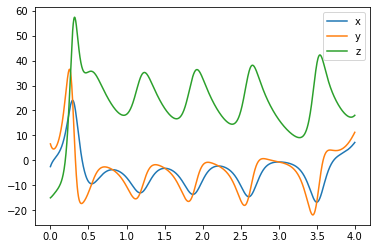

In [4]:
t = w.result[0]
x_t = w.result[1]
plt.figure()
plt.plot(t,x_t[0,:,0],label='x')
plt.plot(t,x_t[0,:,1],label='y')
plt.plot(t,x_t[0,:,2],label='z')
plt.legend()

# Enter SINDy-based inference
What we ended with in the previous section was a *timeseries*, or a signal that changes over time.
Think of this like an EEG, an LFP, or even a spike train.
Our goal is to go from these squigles to a deeper understanding of what's happening in the brain, like 'action potentials' or 'reduced synaptic input'.

This is where SINDy is going to be a powerful tool.
What SINDy does is it takes the sets of 'what's happening in our brain' and tries to see how much each of those things make sense given the timeseries we see.
It then tells us "how much" each of the 'what's happening in our brain' seems to be in our data and builds a model that tries to match it.

In [5]:
def lorenz(z, t):
    return [
        sigma * (z[1] - z[0]),
        z[0] * (rho - z[2]) - z[1],
        z[0] * z[1] - beta * z[2]
    ]

In [6]:
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)

/usr/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


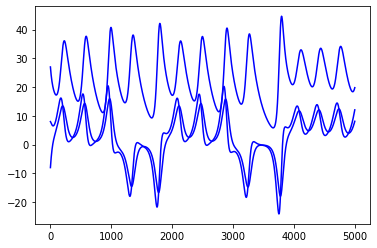

In [7]:
plt.figure()
plt.plot(x_train,color='blue')

model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

## Effects of noise
Finally, we'll explore the impact that noise can have on SINDy's performance.

In [8]:
def noise_exercise(noise_level):
    x_train_noise = x_train + np.random.normal(0,noise_level,size=x_train.shape)
    
    plt.figure()
    plt.plot(x_train_noise,alpha=0.7,color='red')
    plt.plot(x_train,color='blue',alpha=0.3)
    
    model = ps.SINDy()
    model.fit(x_train_noise, t=dt)
    model.print()

noise_widg = interactive(noise_exercise,noise_level=(0.0,1,0.001))
display(noise_widg)

interactive(children=(FloatSlider(value=0.5, description='noise_level', max=1.0, step=0.001), Output()), _dom_…

Unfortunately, it looks like it's very, very sensitive to noise.
But hey, still cool.